# Preprocessing

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import sys
sys.path.append('../src')  
import utils as util

utils good


In [2]:
all_attributes = dir(util)

user_defined = [attr for attr in all_attributes if not attr.startswith('_')]

for attr in user_defined:
    print(attr)

OneHotEncoder
check_data
config_dir
datetime
dump_dataset
joblib
load_config
load_dataset
ohe_input
pd
pickle_dump
pickle_load
ros_fit_resample
rus_fit_resample
smote_fit_resample
yaml


## Load Configuration File

In [3]:
config_data = util.load_config()

## Load Dataset

In [4]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    
    X_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train']
    y_train_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_train']

    X_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_test']
    y_test_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_test']

    X_train = util.pickle_load(X_train_path)
    y_train = util.pickle_load(y_train_path)

    X_test = util.pickle_load(X_test_path)
    y_test = util.pickle_load(y_test_path)

    train_set = pd.concat([X_train, y_train], axis = 1)
    test_set = pd.concat([X_test, y_test], axis = 1)
    
    # dataset = pd.concat([train_set, test_set], axis = 0)
    
    return train_set, test_set 

In [5]:
train_set, test_set  = load_dataset(config_data)

## Train Set

In [6]:
train_set[config_data['data_source']['target_name']].value_counts()

LeaveOrNot
0    2137
1    1120
Name: count, dtype: int64

In [7]:
train_set.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## Test Set

In [8]:
test_set[config_data['data_source']['target_name']].value_counts()

LeaveOrNot
0    916
1    480
Name: count, dtype: int64

In [9]:
test_set.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

## Encoding

In [10]:
def ohe_fit(data_tobe_fitted: dict, ohe_path: str) -> OneHotEncoder:

    ohe_edu = OneHotEncoder(sparse_output = False)
    ohe_edu.fit(np.array(data_tobe_fitted).reshape(-1, 1))

    util.pickle_dump(ohe_edu, ohe_path)
    
    return ohe_edu

In [11]:
def ohe_transform(set_data: pd.DataFrame, tranformed_column: str, ohe_path: str) -> pd.DataFrame:
    set_data = set_data.copy()

    ohe_edu = util.pickle_load(ohe_path)

    stasiun_features = ohe_edu.transform(np.array(set_data[tranformed_column].to_list()).reshape(-1, 1))

    stasiun_features = pd.DataFrame(stasiun_features.tolist(), columns = list(ohe_edu.categories_[0]))

    stasiun_features.set_index(set_data.index, inplace = True)

    set_data = pd.concat([stasiun_features, set_data], axis = 1)

    set_data.drop(columns = tranformed_column, inplace = True)

    new_col = [str(col_name) for col_name in set_data.columns.to_list()]
    set_data.columns = new_col

    return set_data

In [12]:
ohe_education_path = '../' + config_data['ohe_education_path']
ohe_city_path = '../' + config_data['ohe_city_path']
ohe_gender_path = '../' + config_data['ohe_gender_path']
ohe_everbenched_path = '../' + config_data['ohe_everbenched_path']

ohe_education = ohe_fit(config_data['data_defense']['Education']['value'], ohe_education_path)
ohe_city = ohe_fit(config_data['data_defense']['City']['value'], ohe_city_path)
ohe_gender = ohe_fit(config_data['data_defense']['Gender']['value'], ohe_gender_path)
ohe_everbenched = ohe_fit(config_data['data_defense']['EverBenched']['value'], ohe_everbenched_path)

ohe_education

OneHotEncoder(sparse_output=False)

In [13]:
train_set = ohe_transform(train_set, 'Education', ohe_education_path)
train_set = ohe_transform(train_set, 'City', ohe_city_path)
train_set = ohe_transform(train_set, 'Gender', ohe_gender_path)
train_set = ohe_transform(train_set, 'EverBenched', ohe_everbenched_path)

In [14]:
test_set = ohe_transform(test_set, 'Education', ohe_education_path)
test_set = ohe_transform(test_set, 'City', ohe_city_path)
test_set = ohe_transform(test_set, 'Gender', ohe_gender_path)
test_set = ohe_transform(test_set, 'EverBenched', ohe_everbenched_path)

## Sampling

In [15]:
def plot_label_dist(data: pd.DataFrame, target_column: str):
    
    plt.figure(figsize=(4, 4))
    plt.suptitle('Label Distribution', y=0.96)

    g = sns.countplot(x=target_column, 
                      hue=target_column, 
                      data=data, palette='muted')
    g.set(ylabel='Number', xlabel='Target')
    
    plt.show()

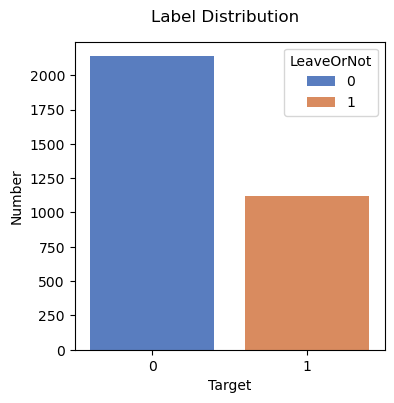

In [16]:
plot_label_dist(train_set, config_data['data_source']['target_name'])

### Random Under Sampling

In [17]:
def rus_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    rus = RandomUnderSampler(random_state = 26)

    x_rus, y_rus = rus.fit_resample(set_data.drop(config_data['data_source']['target_name'], axis = 1), 
                                    set_data[config_data['data_source']['target_name']])
    set_data_rus = pd.concat([x_rus, y_rus], axis = 1)
    return set_data_rus

In [18]:
train_set_rus = rus_fit_resample(train_set)

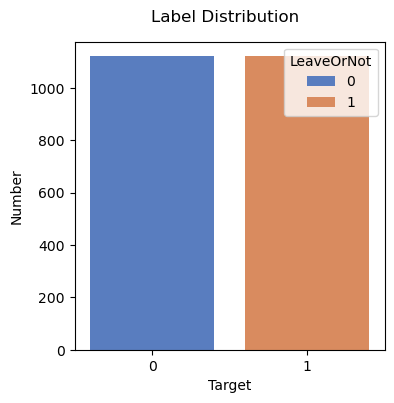

In [21]:
plot_label_dist(train_set_rus, config_data['data_source']['target_name'])

### Random Over Sampling

In [22]:
def ros_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    ros = RandomOverSampler(random_state = 11)

    x_ros, y_ros = ros.fit_resample(set_data.drop(config_data['data_source']['target_name'], axis = 1), 
                                    set_data[config_data['data_source']['target_name']])
    set_data_ros = pd.concat([x_ros, y_ros], axis = 1)
    return set_data_ros

In [24]:
train_set_ros = ros_fit_resample(train_set)

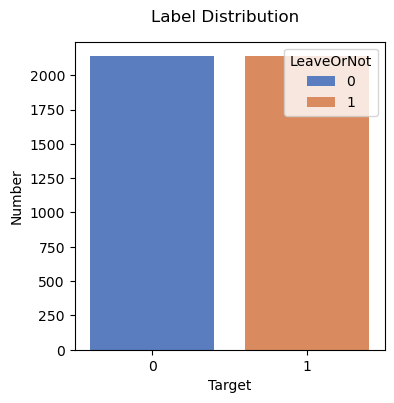

In [25]:
plot_label_dist(train_set_ros, config_data['data_source']['target_name'])

### Synthetic Minority Over-sampling Technique (SMOTE)

In [26]:
def smote_fit_resample(set_data: pd.DataFrame) -> pd.DataFrame:
    set_data = set_data.copy()
    sm = SMOTE(random_state = 112)

    x_sm, y_sm = sm.fit_resample(set_data.drop(config_data['data_source']['target_name'], axis = 1),
                                 set_data[config_data['data_source']['target_name']])
    set_data_sm = pd.concat([x_sm, y_sm], axis = 1)
    return set_data_sm

In [28]:
train_set_smote = smote_fit_resample(train_set)

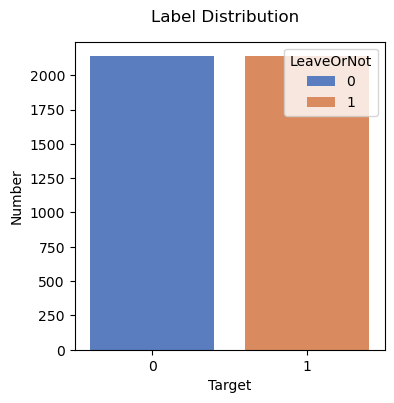

In [27]:
plot_label_dist(train_set_smote, config_data['data_source']['target_name'])

## Dump Data

In [28]:
X_train = {
    'WithoutResampling' : train_set.drop(columns = config_data['data_source']['target_name']),
    'Undersampling' : train_set_rus.drop(columns = config_data['data_source']['target_name']),
    'Oversampling' : train_set_ros.drop(columns = config_data['data_source']['target_name']),
    'SMOTE' : train_set_smote.drop(columns = config_data['data_source']['target_name'])
}

y_train = {
    'WithoutResampling' : train_set[config_data['data_source']['target_name']],
    'Undersampling' : train_set_rus[config_data['data_source']['target_name']],
    'Oversampling' : train_set_ros[config_data['data_source']['target_name']],
    'SMOTE' : train_set_smote[config_data['data_source']['target_name']]
}

In [29]:
X_train['WithoutResampling']

,No,Yes,Female,Male,Bangalore,New Delhi,Pune,Bachelors,Masters,PHD,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain
588,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2014,3,27,5
2638,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2017,2,30,2
4592,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2013,3,28,0
1966,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2013,3,24,2
171,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,2015,3,25,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2016,3,27,5
984,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2015,3,25,3
1213,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2014,3,27,5
2103,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2016,3,29,2


In [30]:
test_set

,No,Yes,Female,Male,Bangalore,New Delhi,Pune,Bachelors,Masters,PHD,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
825,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2012,3,27,5,0
1395,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2014,3,25,3,0
902,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2014,3,25,3,0
3203,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2013,1,39,1,1
2427,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2015,2,29,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3704,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2017,3,41,4,1
2799,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2012,3,28,2,0
4572,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2014,1,22,0,1
2979,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2015,2,26,4,1


In [31]:
X_train_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_train_feng']
y_train_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_train_feng']

X_test_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['X_test_feng']
y_test_feng_path = '../' + config_data['train_test_data']['directory'] + config_data['train_test_data']['y_test_feng']

util.pickle_dump(X_train, X_train_feng_path)
util.pickle_dump(y_train, y_train_feng_path)

util.pickle_dump(test_set.drop(columns = config_data['data_source']['target_name']), X_test_feng_path)
util.pickle_dump(test_set[config_data['data_source']['target_name']], y_test_feng_path)